# Visualization

In [1]:
%load_ext autoreload
%autoreload 2 

import helpers
import config

import torch
import torch.nn as nn
import numpy as np

from models.BasicNet import BasicNet
from train import train_basic
from predict import predict_basic

from models.CNN import CNN
from models.FCN import FCN 

from models.SiameseNet import SiameseNet
from train import train_siamese
from predict import predict_siamese

import torch.utils.data as data
import matplotlib.pyplot as plt
from datasets import PairDataset
from torchsummary import summary

In [2]:
rounds = 10 

## Load data

In [3]:
pairs = helpers.generate_pair_sets(config.NB_SAMPLES)

train_dataset = PairDataset(pairs[0], pairs[1], pairs[2])
train_dataloader = data.DataLoader(dataset=train_dataset, batch_size= config.TRAIN_BATCH_SIZE, shuffle=True)

test_dataset = PairDataset(pairs[3], pairs[4], pairs[5])
test_dataloader = data.DataLoader(dataset=test_dataset, batch_size=config.TEST_BATCH_SIZE, shuffle=True)

## Plot

### Basic Net

In [4]:
summary(BasicNet(), (1 ,2, 14, 14)) 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]         201,216
            Linear-2                    [-1, 1]             513
Total params: 201,729
Trainable params: 201,729
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.77
Estimated Total Size (MB): 0.77
----------------------------------------------------------------


In [22]:
round_results = [] #3D
    
for i in range(rounds):
    print("Round {0}".format(i))

    results = [] #training_losses, training_acc, test_losses, test_acc
    
    model = BasicNet()
    
    training_losses, training_acc, test_losses, test_acc = train_basic(model, train_dataloader, test_dataloader, epochs = config.EPOCHS,  learning_rate= 0.00001)

    results.append([training_losses, training_acc, test_losses, test_acc])
              
    print("With {0} batch size and {1} epochs and {2} learning rate we get :".format(config.TRAIN_BATCH_SIZE, config.EPOCHS, config.LEARNING_RATE))
    
    final_test_loss, final_test_loss_acc = predict_basic(model, test_dataloader)
    print("On the test set we obtain a loss of {:.2f} and an accuracy of {:.2f}".format(final_test_loss,final_test_loss_acc))
      
    round_results.append(results)

Round 0
With 5 batch size and 20 epochs and 0.001 learning rate we get :
On the test set we obtain a loss of 1.82 and an accuracy of 0.71
Round 1
With 5 batch size and 20 epochs and 0.001 learning rate we get :
On the test set we obtain a loss of 1.47 and an accuracy of 0.74
Round 2
With 5 batch size and 20 epochs and 0.001 learning rate we get :
On the test set we obtain a loss of 1.70 and an accuracy of 0.69
Round 3
With 5 batch size and 20 epochs and 0.001 learning rate we get :
On the test set we obtain a loss of 1.93 and an accuracy of 0.69
Round 4
With 5 batch size and 20 epochs and 0.001 learning rate we get :
On the test set we obtain a loss of 1.60 and an accuracy of 0.72
Round 5
With 5 batch size and 20 epochs and 0.001 learning rate we get :
On the test set we obtain a loss of 1.51 and an accuracy of 0.72
Round 6
With 5 batch size and 20 epochs and 0.001 learning rate we get :
On the test set we obtain a loss of 1.61 and an accuracy of 0.72
Round 7
With 5 batch size and 20 e

In [23]:
means = np.array(round_results).mean(axis= 0).reshape((4,20))
std  = np.array(round_results).std(axis = 0).reshape((4,20))

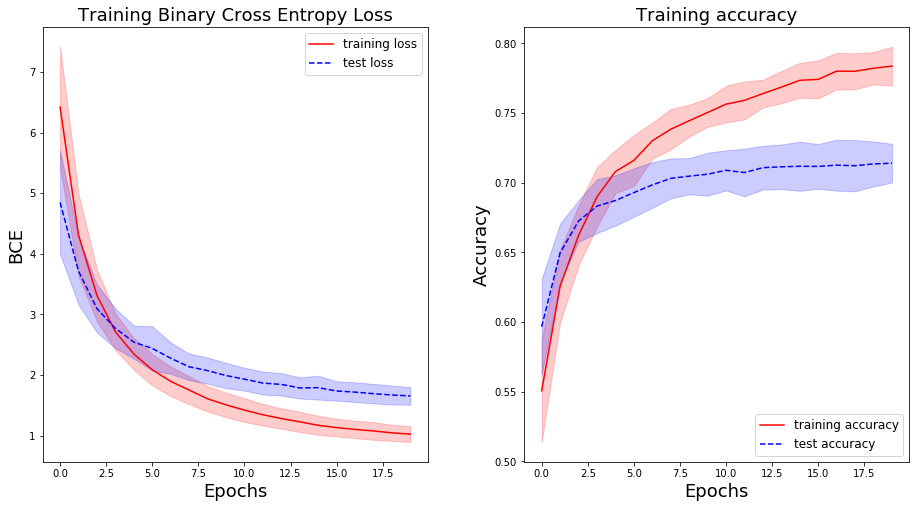

In [46]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize= (14,8))

ax1.plot(means[0], color = 'r', label = 'training loss')
ax1.plot(means[2], color = 'b',  linestyle='dashed', label = 'test loss')
        
ax1.fill_between(range(len(means[0])), means[0] - std[0], means[0] + std[0], alpha = 0.2, color = 'r')
ax1.fill_between(range(len(means[2])), means[2] - std[2], means[2] + std[2], alpha = 0.2, color = 'b')

ax2.plot(means[1], color = 'r', label = 'training accuracy')
ax2.plot(means[3], color = 'b', linestyle='dashed', label = 'test accuracy')

ax2.fill_between(range(len(means[1])), means[1]- std[1], means[1]+ std[1], alpha = 0.2, color = 'r')
ax2.fill_between(range(len(means[3])), means[3]- std[3], means[3]+ std[3], alpha = 0.2, color = 'b')

ax1.set_title('Training Binary Cross Entropy Loss',{'fontsize':18})
ax1.set_xlabel("Epochs",{'fontsize':18})
ax1.set_ylabel("BCE",{'fontsize':18})

ax2.set_title('Training accuracy',{'fontsize':18})
ax2.set_xlabel("Epochs",{'fontsize':18})
ax2.set_ylabel("Accuracy",{'fontsize':18})

ax1.legend(loc = 'upper right',fontsize= 'large')
ax2.legend(loc = 'lower right',fontsize= 'large')
plt.subplots_adjust(left=0.07, right=0.93, wspace=0.25, hspace=0.35)
plt.show()

In [33]:
means[3,19] #test_accuracy

0.714

In [34]:
std[3,19]

0.013957077057894333

### Siamese Net

We want to assess the difference w/o aux loss and weight sharing for each subnet configuration

In [5]:
configuration = [
    (weight_sharing, aux_loss)
    
    for weight_sharing in [False,True]
    for aux_loss in [False,True]
]
configuration

[(False, False), (False, True), (True, False), (True, True)]

In [6]:
def compute_results_fcn(subnet_type, nb_hidden_layers = config.FCN_NB_HIDDEN, 
                    hidden_layer = config.FCN_HIDDEN_LAYER,
                    nb_hidden_layers_out = config.SIAMESE_NET_NB_HIDDEN,
                    hidden_layer_out = config.SIAMESE_NET_HIDDEN_LAYER,
                    alpha = config.ALPHA): 

    round_results = []

    for i in range(rounds):
        results = [] #training_losses, training_acc, test_losses, test_acc
        
        for weight_sharing, aux_loss in configuration:
            subnet1 = FCN(nb_hidden_layers, hidden_layer)
            subnet2 = FCN(nb_hidden_layers, hidden_layer)
            
            print('Model for weight_sharing = {0} and aux loss = {1} on round {2} with subnet {3}'.format(weight_sharing, aux_loss, 
                                                                                                          i,subnet_type))
            
            if(weight_sharing):
                model = SiameseNet(subnet1, None, nb_hidden_layers_out, hidden_layer_out)
            else: 
                model = SiameseNet(subnet1, subnet2, nb_hidden_layers_out, hidden_layer_out)
            
            training_losses, training_acc, _, _, test_losses, test_acc, _, _ = train_siamese(
                    model = model, dataloader = train_dataloader, test_dataloader = test_dataloader, aux_loss = aux_loss, alpha = alpha)        
            
            final_test_loss, final_test_loss_acc, _, _ = predict_siamese(model, test_dataloader, aux_loss, alpha)
            print("In epoch 20, on the test set we obtain a loss of {:.2f} and an accuracy of {:.2f}".format(final_test_loss,final_test_loss_acc))
            results.append([training_losses, training_acc, test_losses, test_acc])

        round_results.append(results)

    return round_results

In [7]:
def compute_results_cnn(subnet_type, nb_hidden_layers = config.CNN_NB_HIDDEN, 
                    base_channel_size = config.CNN_BASE_CHANNEL_SIZE, 
                    hidden_layer = config.CNN_HIDDEN_LAYER,
                    kernel_size = config.CNN_KERNEL_SIZE,
                    nb_hidden_layers_out = config.SIAMESE_NET_NB_HIDDEN,
                    hidden_layer_out = config.SIAMESE_NET_HIDDEN_LAYER,
                    alpha = config.ALPHA): 

    round_results = []

    for i in range(rounds):
        results = [] #training_losses, training_acc, test_losses, test_acc
        
        for weight_sharing, aux_loss in configuration:
            subnet1 = CNN(nb_hidden_layers, base_channel_size, hidden_layer, kernel_size)
            subnet2 = CNN(nb_hidden_layers, base_channel_size, hidden_layer, kernel_size)
            
            print('Model for weight_sharing = {0} and aux loss = {1} on round {2} with subnet {3}'.format(weight_sharing, aux_loss, 
                                                                                                          i,subnet_type))
            
            if(weight_sharing):
                model = SiameseNet(subnet1, None, nb_hidden_layers_out, hidden_layer_out)
            else: 
                model = SiameseNet(subnet1, subnet2, nb_hidden_layers_out, hidden_layer_out)
            
            training_losses, training_acc, _, _, test_losses, test_acc, _, _ = train_siamese(
                    model = model, dataloader = train_dataloader, test_dataloader = test_dataloader, aux_loss = aux_loss, alpha = alpha)        
            
            final_test_loss, final_test_loss_acc, _, _ = predict_siamese(model, test_dataloader, aux_loss, alpha)
            print("In epoch 20, on the test set we obtain a loss of {:.2f} and an accuracy of {:.2f}".format(final_test_loss,final_test_loss_acc))
            results.append([training_losses, training_acc, test_losses, test_acc])

        round_results.append(results)

    return round_results

In [53]:
def plots_results(round_results, subnet_type):
    
    colors = ['b', 'g', 'r', 'm']

    fig, (ax1, ax2) = plt.subplots(1, 2,figsize= (14,8))

    means = np.array(round_results).mean(axis= 0)
    std  = np.array(round_results).std(axis = 0)
    dict_word = {False :'without', True : 'with'}
    for i, (r,s,p) in enumerate( zip(means,std,configuration) ):

        ax1.plot(r[0], color = colors[i], label = 'training loss {0} WS and {1} AL'.format(dict_word[p[0]], dict_word[p[1]]))
        ax1.plot(r[2], color = colors[i],  linestyle='dashed', label = 'test loss {0} WS and {1} AL'.format(dict_word[p[0]], dict_word[p[1]]))

        ax1.fill_between(range(len(r[0])), r[0] - s[0], r[0]+ s[0], alpha = 0.2, color = colors[i])
        ax1.fill_between(range(len(r[2])), r[2]- s[2], r[2]+ s[2], alpha = 0.2, color = colors[i])

        ax2.plot(r[1], color = colors[i], label = 'training accuracy {0} WS and {1} AL'.format(dict_word[p[0]], dict_word[p[1]]))
        ax2.plot(r[3], color = colors[i], linestyle='dashed', label = 'test accuracy {0} WS and {1} AL'.format(dict_word[p[0]], dict_word[p[1]]))

        ax2.fill_between(range(len(r[1])), r[1]- s[1], r[1]+ s[1], alpha = 0.2, color = colors[i])
        ax2.fill_between(range(len(r[3])), r[3]- s[3], r[3]+ s[3], alpha = 0.2, color = colors[i])

    ax1.set_title('Training Binary Cross Entropy with {0} subnets'.format(subnet_type),{'fontsize':18})
    ax1.set_xlabel("Epochs",{'fontsize':18})
    ax1.set_ylabel("BCE",{'fontsize':18})

    ax2.set_title('Training accuracy with {0} subnets'.format(subnet_type),{'fontsize':18})
    ax2.set_xlabel("Epochs",{'fontsize':18})
    ax2.set_ylabel("Accuracy",{'fontsize':18})

    ax1.legend(loc = 'upper right',fontsize= 'large')
    ax2.legend(loc = 'lower right',fontsize= 'large')
    plt.subplots_adjust(left=0.07, right=0.93, wspace=0.25, hspace=0.35)
    plt.show()

#### Subnets : FCN 

In [14]:
FCN()

FCN(
  (hiddens): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=196, out_features=64, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Dropout(p=0.2)
    )
  )
  (output): Linear(in_features=64, out_features=10, bias=True)
)

In [57]:
round_results_FCN = compute_results_fcn('FCN')

Model for weight_sharing = False and aux loss = False on round 0 with subnet FCN
In epoch 20, on the test set we obtain a loss of 0.82 and an accuracy of 0.84
Model for weight_sharing = False and aux loss = True on round 0 with subnet FCN
In epoch 20, on the test set we obtain a loss of 0.58 and an accuracy of 0.88
Model for weight_sharing = True and aux loss = False on round 0 with subnet FCN
In epoch 20, on the test set we obtain a loss of 0.59 and an accuracy of 0.85
Model for weight_sharing = True and aux loss = True on round 0 with subnet FCN
In epoch 20, on the test set we obtain a loss of 0.38 and an accuracy of 0.90
Model for weight_sharing = False and aux loss = False on round 1 with subnet FCN
In epoch 20, on the test set we obtain a loss of 0.76 and an accuracy of 0.83
Model for weight_sharing = False and aux loss = True on round 1 with subnet FCN
In epoch 20, on the test set we obtain a loss of 0.54 and an accuracy of 0.88
Model for weight_sharing = True and aux loss = Fals

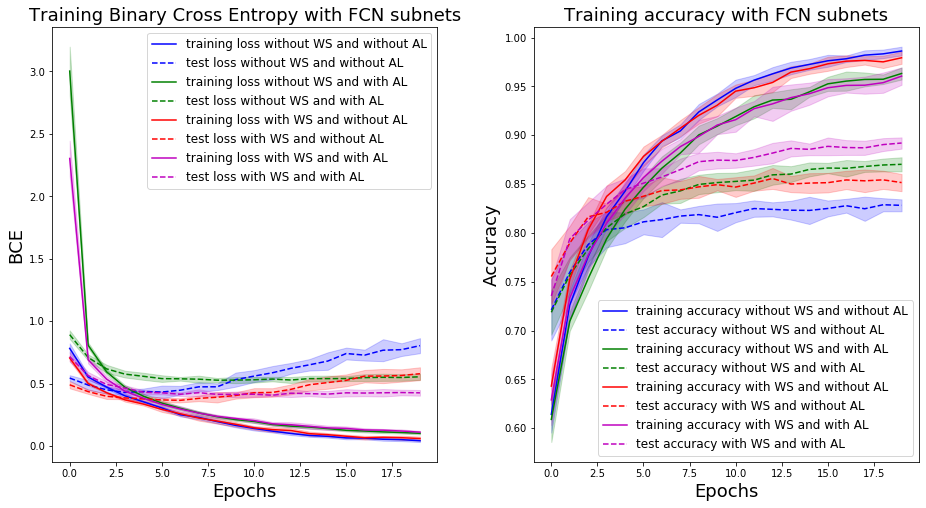

In [58]:
plots_results(round_results_FCN,'FCN')

In [61]:
means_FCN = np.array(round_results_FCN).mean(axis= 0)
means_FCN[:,3,19] #test_accuracy

array([0.8282, 0.8702, 0.8515, 0.892 ])

In [62]:
std_FCN = np.array(round_results_FCN).std(axis= 0)
std_FCN[:,3,19] #test_accuracy

array([0.0060959 , 0.00719444, 0.00880057, 0.00577927])

#### Best FCN

In [10]:
round_results_best_FCN = compute_results_fcn('FCN', nb_hidden_layers = config.FCN_BEST_NB, 
                                             hidden_layer = config.FCN_BEST_HIDDEN,
                                             nb_hidden_layers_out = config.SIAMESE_NET_BEST_NB_FCN, 
                                             hidden_layer_out = config.SIAMESE_NET_BEST_HIDDEN_FCN, 
                                             alpha = config.BEST_ALPHA_FCN)

Model for weight_sharing = False and aux loss = False on round 0 with subnet FCN
In epoch 20, on the test set we obtain a loss of 0.99 and an accuracy of 0.83
Model for weight_sharing = False and aux loss = True on round 0 with subnet FCN
In epoch 20, on the test set we obtain a loss of 0.51 and an accuracy of 0.91
Model for weight_sharing = True and aux loss = False on round 0 with subnet FCN
In epoch 20, on the test set we obtain a loss of 0.55 and an accuracy of 0.87
Model for weight_sharing = True and aux loss = True on round 0 with subnet FCN
In epoch 20, on the test set we obtain a loss of 0.34 and an accuracy of 0.93
Model for weight_sharing = False and aux loss = False on round 1 with subnet FCN
In epoch 20, on the test set we obtain a loss of 1.12 and an accuracy of 0.82
Model for weight_sharing = False and aux loss = True on round 1 with subnet FCN
In epoch 20, on the test set we obtain a loss of 0.43 and an accuracy of 0.90
Model for weight_sharing = True and aux loss = Fals

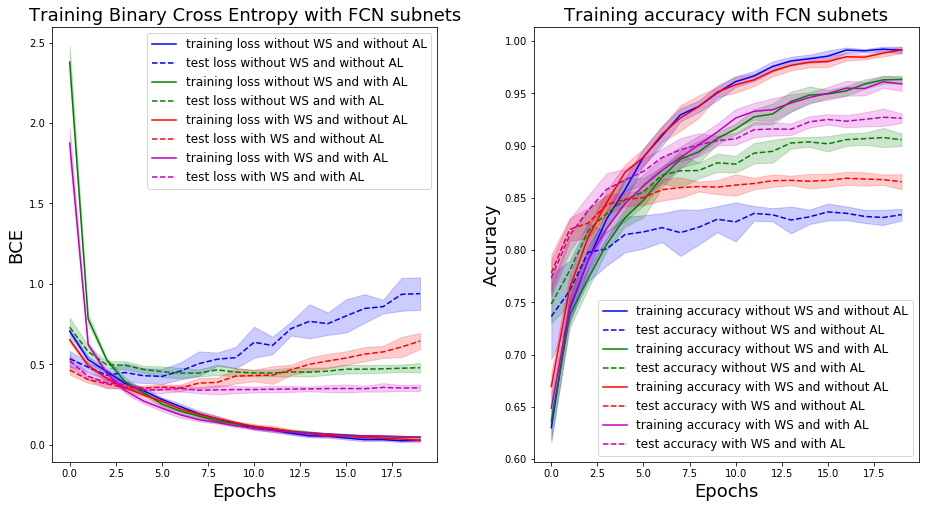

In [54]:
plots_results(round_results_best_FCN,'FCN')

In [11]:
means_best_FCN = np.array(round_results_best_FCN).mean(axis= 0)
means_best_FCN[:,3,19] #test_accuracy

array([0.834 , 0.9057, 0.8655, 0.9263])

In [12]:
std_best_FCN = np.array(round_results_best_FCN).std(axis= 0)
std_best_FCN[:,3,19] #test_accuracy

array([0.00556776, 0.0061    , 0.00725603, 0.00451774])

#### Subnet : CNN

In [13]:
CNN()

CNN(
  (conv_net): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.2)
    (4): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1))
    (5): LeakyReLU(negative_slope=0.01)
    (6): Dropout(p=0.2)
  )
  (fc_net): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=128, out_features=64, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Dropout(p=0.2)
    )
  )
  (output): Linear(in_features=64, out_features=10, bias=True)
)

In [14]:
round_results_CNN = compute_results_cnn('CNN')

Model for weight_sharing = False and aux loss = False on round 0 with subnet CNN
In epoch 20, on the test set we obtain a loss of 0.39 and an accuracy of 0.81
Model for weight_sharing = False and aux loss = True on round 0 with subnet CNN
In epoch 20, on the test set we obtain a loss of 0.30 and an accuracy of 0.90
Model for weight_sharing = True and aux loss = False on round 0 with subnet CNN
In epoch 20, on the test set we obtain a loss of 0.34 and an accuracy of 0.87
Model for weight_sharing = True and aux loss = True on round 0 with subnet CNN
In epoch 20, on the test set we obtain a loss of 0.23 and an accuracy of 0.91
Model for weight_sharing = False and aux loss = False on round 1 with subnet CNN
In epoch 20, on the test set we obtain a loss of 0.37 and an accuracy of 0.84
Model for weight_sharing = False and aux loss = True on round 1 with subnet CNN
In epoch 20, on the test set we obtain a loss of 0.32 and an accuracy of 0.88
Model for weight_sharing = True and aux loss = Fals

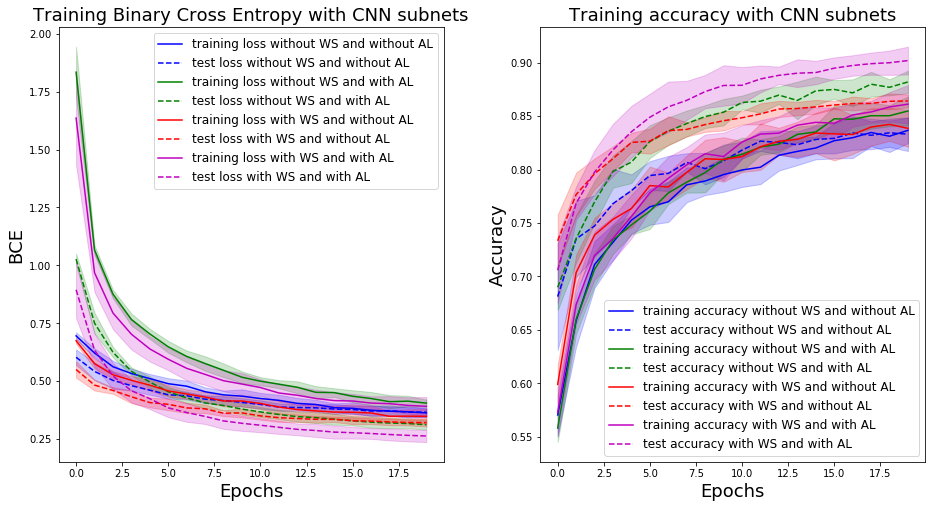

In [55]:
plots_results(round_results_CNN, 'CNN')

In [16]:
means_CNN = np.array(round_results_CNN).mean(axis= 0)
means_CNN[:,3,19] #test_accuracy

array([0.8331, 0.882 , 0.8642, 0.902 ])

In [17]:
std_CNN = np.array(round_results_CNN).std(axis= 0)
std_CNN[:,3,19] #test_accuracy

array([0.01575722, 0.01058301, 0.00597997, 0.01300769])

#### Best CNN

In [27]:
round_results_best_CNN = compute_results_cnn('CNN', nb_hidden_layers = config.CNN_BEST_NB, 
                                            base_channel_size = config.CNN_BEST_CHANNEL, 
                                            hidden_layer = config.CNN_BEST_HIDDEN,
                                            kernel_size = config.CNN_BEST_KERNEL_SIZE,
                                            nb_hidden_layers_out = config.SIAMESE_NET_BEST_NB_CNN,
                                            hidden_layer_out = config.SIAMESE_NET_BEST_HIDDEN_CNN,
                                            alpha = config.BEST_ALPHA_CNN)

Model for weight_sharing = False and aux loss = False on round 0 with subnet CNN
In epoch 20, on the test set we obtain a loss of 0.43 and an accuracy of 0.86
Model for weight_sharing = False and aux loss = True on round 0 with subnet CNN
In epoch 20, on the test set we obtain a loss of 0.25 and an accuracy of 0.95
Model for weight_sharing = True and aux loss = False on round 0 with subnet CNN
In epoch 20, on the test set we obtain a loss of 0.32 and an accuracy of 0.92
Model for weight_sharing = True and aux loss = True on round 0 with subnet CNN
In epoch 20, on the test set we obtain a loss of 0.17 and an accuracy of 0.97
Model for weight_sharing = False and aux loss = False on round 1 with subnet CNN
In epoch 20, on the test set we obtain a loss of 0.48 and an accuracy of 0.88
Model for weight_sharing = False and aux loss = True on round 1 with subnet CNN
In epoch 20, on the test set we obtain a loss of 0.23 and an accuracy of 0.95
Model for weight_sharing = True and aux loss = Fals

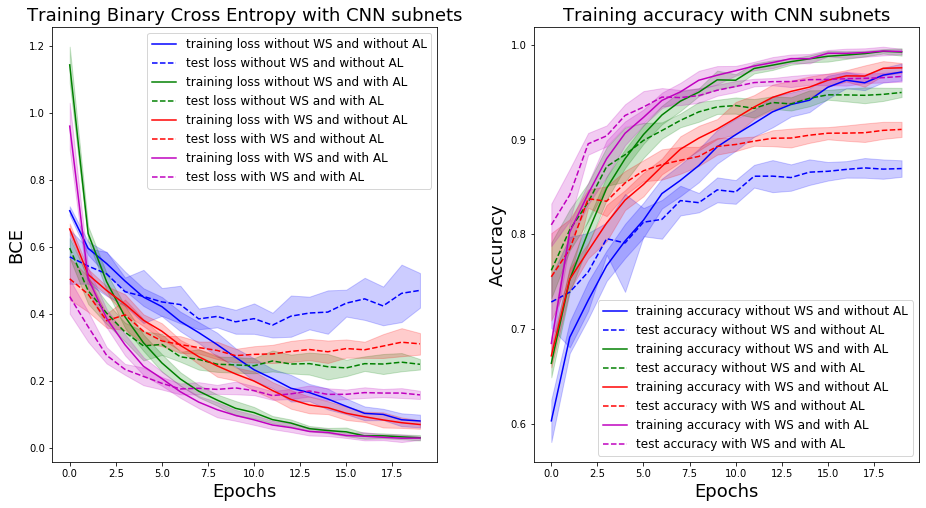

In [56]:
plots_results(round_results_best_CNN, 'CNN')

In [29]:
means_best_CNN = np.array(round_results_best_CNN).mean(axis= 0)
means_best_CNN[:,3,19] #test_accuracy

array([0.8691, 0.9494, 0.9104, 0.9663])

In [30]:
std_best_CNN = np.array(round_results_best_CNN).std(axis= 0)
std_best_CNN[:,3,19] #test_accuracy

array([0.00871149, 0.00484149, 0.00798999, 0.00558659])